# +++++++++++++++++++++++++++++++++++++++++++++

# Load Datasets

# +++++++++++++++++++++++++++++++++++++++++++++

In [12]:
import sys
sys.path.append('../../../utils/')

import pandas as pd
import numpy as np

In [3]:
#pip install biopython

from Bio import SeqIO
identifiers = []
sequences=[]
with open('../../../data/REALoc/S1_dataset/5939pdataset/Sequence/Cell_membrane.txt') as fasta_file:  # Will close handle cleanly   
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))

with open('../../../data/REALoc/S1_dataset/5939pdataset/Sequence/Cytoplasm.txt') as fasta_file:  # Will close handle cleanly   
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))
with open('../../../data/REALoc/S1_dataset/5939pdataset/Sequence/ER_Golgi.txt') as fasta_file:  # Will close handle cleanly   
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))
with open('../../../data/REALoc/S1_dataset/5939pdataset/Sequence/Mitochondrion.txt') as fasta_file:  # Will close handle cleanly   
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))
with open('../../../data/REALoc/S1_dataset/5939pdataset/Sequence/Nucleus.txt') as fasta_file:  # Will close handle cleanly   
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))
with open('../../../data/REALoc/S1_dataset/5939pdataset/Sequence/Secreted.txt') as fasta_file:  # Will close handle cleanly   
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))

        

In [4]:
df=pd.DataFrame(data=list(zip(identifiers,sequences)),columns=['UniprotID','sequence'])

train_df=df.drop_duplicates()

trainDatasetFile='../../../data/REALoc/S1_dataset/5939pdataset/idLocation.txt'

labels=pd.read_csv(trainDatasetFile,sep='|',header=None)

labels.columns=['UniprotID','label']

In [5]:
trainDataset_merged=labels.merge(train_df)

In [6]:
trainDataset_merged.shape

(5939, 3)

In [7]:
trainDataset_merged.head()

,UniprotID,label,sequence
0,O95866,Cell_membrane,MAVFLQLLPLLLSRAQGNPGASLDGRPGDRVNLSCGGVSHPIRWVW...
1,Q70Z44,Cell_membrane,MQKHSPGPPALALLSQSLLTTGNGDTLIINCPGFGQHRVDPAAFQA...
2,Q5I7T1,Cell_membrane,MAQLEGYCFSAALSCTFLVSCLLFSAFSRALREPYMDEIFHLPQAQ...
3,O14514,Cell_membrane,MRGQAAAPGPVWILAPLLLLLLLLGRRARAAAGADAGPGPEPCATL...
4,Q9H159,Cell_membrane,MNCYLLLRFMLGIPLLWPCLGATENSQTKKVKQPVRSHLRVKRGWV...


# pre process lables

In [10]:
trainLables=trainDataset_merged[['label']]

In [13]:
#trainLables=trainDataset[[1]]
multiplexProteinsIndicesTrain=[]
trainLablesOneHot=np.zeros(shape=(trainLables.shape[0],6))

lableDict={'Cell_membrane':0,'Cytoplasm':1,'ER_Golgi':2,'Mitochondrion':3,'Nucleus':4,'Secreted':5}

for i,row in trainLables.iterrows():
    lables=row.str.split(' ')
    lables=list(lables)
    lables=lables[0]
    lables=lables[:-1]
    if len(lables)> 1:
        multiplexProteinsIndicesTrain.append(i)
    for lable in lables:
        trainLablesOneHot[i,lableDict[lable]]=1


In [14]:
trainLablesOneHot.shape

(5939, 6)

In [18]:
lableDict_reversed={0:'Cell Membrane',
 1:'Cytoplasm',
 2:'ER Golgi',
 3:'Mitochondrion',
 4:'Nucleus',
 5:'Secreted'}

## Exclude multilex proteins

In [15]:
multiplexProteinsIndicesTrain=np.array(multiplexProteinsIndicesTrain)
include_idx = set(multiplexProteinsIndicesTrain)
mask = np.array([(i in include_idx) for i in range(len(trainDataset_merged))])


In [19]:
y_trainSingleplex=trainLablesOneHot[~mask]
y_trainSingleplex= np.argmax (y_trainSingleplex,axis=1)
labels=[lableDict_reversed[i] for i in y_trainSingleplex ]


# Generate Unirep Embeddings

* Attention
* 
* Run This Part If you want to re-generate embeddings for each size (64,256, and 1900)
* Or
* you can use pre-generated embedding pickles


In [34]:
import tensorflow as tf

tf.set_random_seed(42)
np.random.seed(42)
embedding_size=64

if embedding_size==64:
        
   # Import the mLSTM babbler model
    from unirep import babbler64 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "../../../data/Unirep/64_weights"
    
    batch_size = 1
    b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)
    
elif embedding_size==256:
    # Sync relevant weight files
    #######################  UN COMMENT TO DOWLOAD ##!aws s3 sync --no-sign-request --quiet s3://unirep-public/256_weights/ 256_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler256 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "../../../data/Unirep/256_weights"
    
    batch_size = 1

    b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)
    
else:
    # Sync relevant weight files
    #!aws s3 sync --no-sign-request --quiet s3://unirep-public/64_weights/ 64_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler1900 as babbler
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "../../../data/Unirep/1900_weights/"
    
    batch_size = 1
    
    b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)

train_sequences=trainDataset_merged['sequence']

#actual embedding values will be replaced if is exist
train_embeddings=np.random.rand(train_sequences.shape[0],embedding_size)

valid_counts=0
for i,seq in enumerate(train_sequences):   
    if i%10==0:
        tf.reset_default_graph()        
        del b
        b = babbler(batch_size=1, model_path=MODEL_WEIGHT_PATH)
        print(i)
    if b.is_valid_seq(seq):
        #if lengths[i]<500:
            valid_counts+=1
            #get average hidden states
            train_embeddings[i]=b.get_rep(seq)[0]

# Visualize using Unirep Embeddings

In [21]:
from sklearn.manifold import TSNE
import seaborn as sns


## Using pre-generated Embeddings

In [17]:
import pickle

### Visulalize using Unirep 64D

In [22]:

# with open('Unirep64_embeddings_5939.pickle','wb') as handle:
#     pickle.dump(train_embeddings_unirep_64,handle)
#     pickle.dump(trainDataset,handle)

with open('../../../data/Unirep/Unirep64_embeddings_5939.pickle', "rb") as f:
    train_embeddings_unirep_64=pickle.load(f)

X_trainSingleplex=train_embeddings_unirep_64[~mask]
tsne = TSNE(n_components=2, verbose=1, n_iter=5000)
tsne_results = tsne.fit_transform(X_trainSingleplex)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5026 samples in 0.019s...
[t-SNE] Computed neighbors for 5026 samples in 1.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5026
[t-SNE] Computed conditional probabilities for sample 2000 / 5026
[t-SNE] Computed conditional probabilities for sample 3000 / 5026
[t-SNE] Computed conditional probabilities for sample 4000 / 5026
[t-SNE] Computed conditional probabilities for sample 5000 / 5026
[t-SNE] Computed conditional probabilities for sample 5026 / 5026
[t-SNE] Mean sigma: 0.110389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.800903
[t-SNE] KL divergence after 5000 iterations: 1.488642


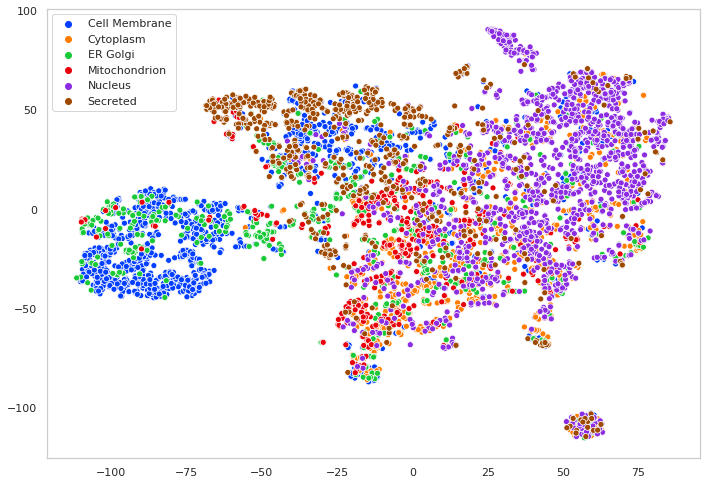

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 6)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=labels, palette=palette)

### Visulalize using Unirep 256D

In [32]:

# with open('Unirep256_embeddings_5939.pickle','wb') as handle:
#     pickle.dump(train_embeddings_unirep_256,handle)
#     pickle.dump(trainDataset,handle)

with open('../../../data/Unirep/Unirep256_embeddings_5939.pickle', "rb") as f:
    train_embeddings_unirep_256=pickle.load(f)

X_trainSingleplex=train_embeddings_unirep_256[~mask]
tsne = TSNE(n_components=2, verbose=1, n_iter=5000)
tsne_results = tsne.fit_transform(X_trainSingleplex)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5026 samples in 0.082s...
[t-SNE] Computed neighbors for 5026 samples in 8.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5026
[t-SNE] Computed conditional probabilities for sample 2000 / 5026
[t-SNE] Computed conditional probabilities for sample 3000 / 5026
[t-SNE] Computed conditional probabilities for sample 4000 / 5026
[t-SNE] Computed conditional probabilities for sample 5000 / 5026
[t-SNE] Computed conditional probabilities for sample 5026 / 5026
[t-SNE] Mean sigma: 0.195578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.683884
[t-SNE] KL divergence after 5000 iterations: 1.498857


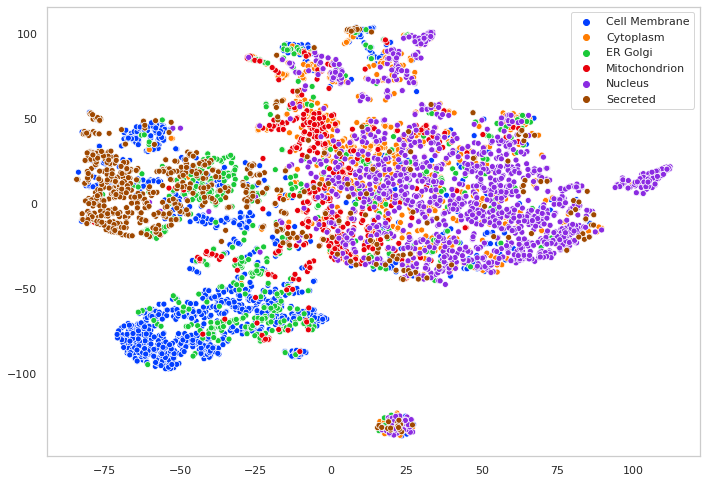

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 6)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=labels, palette=palette)

### Visulalize using Unirep 1900D

In [34]:

# with open('Unirep1900_embeddings_5939.pickle','wb') as handle:
#     pickle.dump(train_embeddings_unirep_1900,handle)
#     pickle.dump(trainDataset,handle)

with open('../../../data/Unirep/Unirep256_embeddings_5939.pickle', "rb") as f:
    train_embeddings_unirep_1900=pickle.load(f)

X_trainSingleplex=train_embeddings_unirep_1900[~mask]
tsne = TSNE(n_components=2, verbose=1, n_iter=5000)
tsne_results = tsne.fit_transform(X_trainSingleplex)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5026 samples in 0.089s...
[t-SNE] Computed neighbors for 5026 samples in 8.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5026
[t-SNE] Computed conditional probabilities for sample 2000 / 5026
[t-SNE] Computed conditional probabilities for sample 3000 / 5026
[t-SNE] Computed conditional probabilities for sample 4000 / 5026
[t-SNE] Computed conditional probabilities for sample 5000 / 5026
[t-SNE] Computed conditional probabilities for sample 5026 / 5026
[t-SNE] Mean sigma: 0.195578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.678757
[t-SNE] KL divergence after 5000 iterations: 1.498326


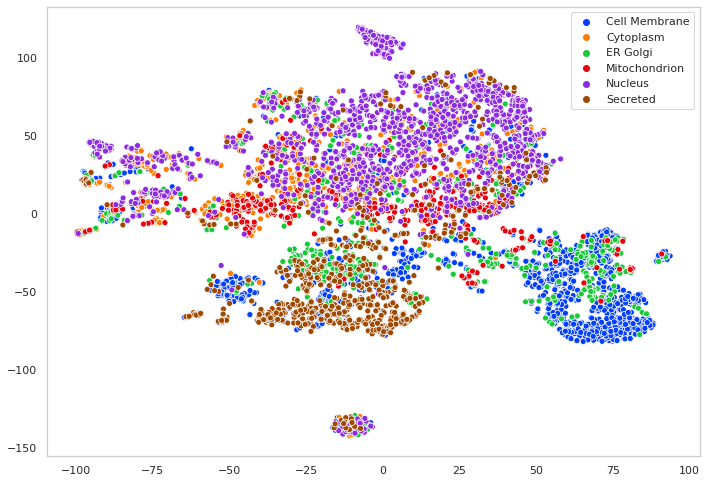

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 6)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=labels, palette=palette)

# Visualize using TripletProt 64D

### map uniprot to String

In [55]:
dfTrain=trainDataset_merged[['UniprotID']]

dfTrain.columns=['uniprot_ac']

mapString2Uniprot=pd.read_csv('../../../data/all_organisms.uniprot_2_string.2018.tsv',sep='\t',skiprows=1,usecols=[1,2])

In [56]:
dfTrain.shape

(5939, 1)

In [57]:
#mapString2Uniprot.columns=['species', 'uniprot_ac_uniprot_id', 'string_id', 'identity' ,'bit_score']
mapString2Uniprot.columns=['uniprot_ac_uniprot_id', 'string_id']

mapString2Uniprot['uniprot_ac'] = mapString2Uniprot.uniprot_ac_uniprot_id.str.split('|').str[0]

dfTrain=pd.merge(dfTrain,mapString2Uniprot,on=['uniprot_ac'],how='left')


dfTrain.shape

#140 out of 5939 with no string id
len(np.nonzero (pd.isna(dfTrain['string_id']))[0])


#import pickle

# with open('2017/S1_dataset/5939pdataset/dfTrainMapUniprot2String.pickle','wb') as handle:
#     pickle.dump(dfTrain,handle)
    

/home/ubuntuadmin/anaconda37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


140

### Generate TripletProt embeddings

In [58]:
import pickle
import tensorflow as tf
from keras import backend as K
from keras.models import load_model


def identity_loss(y_true, y_pred):

    return K.mean(y_pred - 0 * y_true)

with open('../../../data/pickles/StringIDs.pickle', "rb") as f:
    proteins=pickle.load(f)


In [60]:
embedding_modebl = load_model('../../../Saved_Models/trained_model_to_generate_embeddings.h5',custom_objects={ 'identity_loss': identity_loss })


def generate_vector(model, uid):

    vector = model.get_layer('embedding').get_weights()[0][uid]

    return vector


In [61]:
embedding_size=64

lenMax=len(proteins)

trainProtein_weights = np.zeros((dfTrain.shape[0], embedding_size))

trainProtein_weights.shape


c_found=0
for i,row in dfTrain.iterrows():
    try:
        protein_id=np.searchsorted(proteins,row['string_id'])
        if protein_id != lenMax:
            c_found += 1
            trainProtein_weights[i]=generate_vector(embedding_modebl,protein_id)
        else:
            trainProtein_weights[i]=np.random.rand(embedding_size)
    except:
            trainProtein_weights[i]=np.random.rand(embedding_size)

    

dfTrain.shape

print('number of found: ',c_found)

trainProtein_weights=pd.DataFrame(trainProtein_weights)

X_train=trainProtein_weights

trainProtein_weights=np.array(trainProtein_weights)

X_trainSingleplex=trainProtein_weights[~mask]


number of found:  5799


In [64]:
tsne = TSNE(n_components=2, verbose=1, n_iter=5000)
tsne_results = tsne.fit_transform(X_trainSingleplex)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5026 samples in 0.021s...
[t-SNE] Computed neighbors for 5026 samples in 1.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5026
[t-SNE] Computed conditional probabilities for sample 2000 / 5026
[t-SNE] Computed conditional probabilities for sample 3000 / 5026
[t-SNE] Computed conditional probabilities for sample 4000 / 5026
[t-SNE] Computed conditional probabilities for sample 5000 / 5026
[t-SNE] Computed conditional probabilities for sample 5026 / 5026
[t-SNE] Mean sigma: 0.957523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.137482
[t-SNE] KL divergence after 5000 iterations: 1.529621


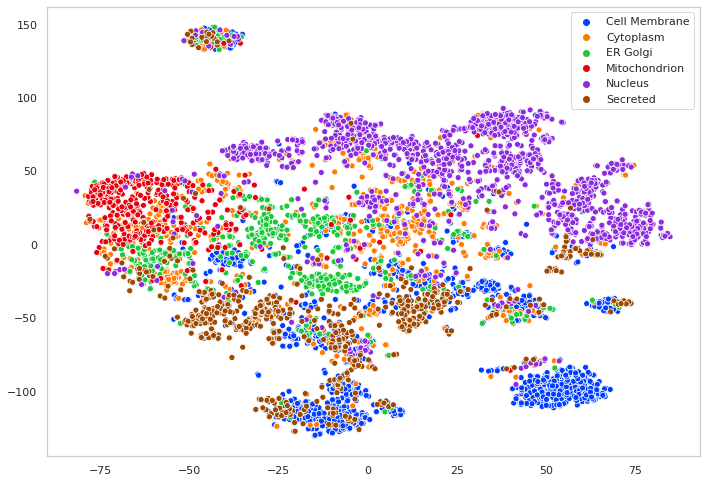

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 6)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=labels, palette=palette)